<a href="https://colab.research.google.com/github/sioulruble/SER_ShEMO_LSTM_HuBERT/blob/main/SER_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! pip install pydub
# ! pip install -U datasets
# ! pip install -U accelerate
# ! pip install -U transformers

In [ ]:
import numpy as np
import pandas as pd
import os
import pandas as pd

import torchaudio
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/',force_remount=True)

zip_ref = zipfile.ZipFile("/content/drive/My Drive/dataset.zip", 'r')
zip_ref.extractall("/tmp")

Mounted at /content/drive/


In [ ]:
label_to_one_hot = {'A': [1, 0, 0, 0, 0, 0], 'N': [0, 1, 0, 0, 0, 0], 'S': [0, 0, 1, 0, 0, 0], 'F': [0, 0, 0, 1, 0, 0],
                    'W': [0, 0, 0, 0, 1, 0], 'H': [0, 0, 0, 0, 0, 1]}

class GeneralDataset(Dataset):
    def __init__(self, male_directory, female_directory, target_sample_rate, max_len=None):
        self.male_files = [(os.path.join(male_directory, f), 'male') for f in os.listdir(male_directory)]
        self.female_files = [(os.path.join(female_directory, f), 'female') for f in os.listdir(female_directory)]
        self.files = self.male_files + self.female_files
        self.target_sample_rate = target_sample_rate
        self.max_len = max_len

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, gender = self.files[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
        waveform = resampler(waveform)
        label = self.extract_label_char_from_filename(file_path)
        waveform = waveform.squeeze().numpy()
        return waveform, label
    @staticmethod
    def extract_label_char_from_filename(filename):
        char_label = filename.split('/')[-1][3]
        return char_label
    @staticmethod
    def extract_label_onehot_from_filename(filename):
        return GeneralDataset.label_char_to_one_hot(GeneralDataset.extract_label_char_from_filename(filename))
    @staticmethod
    def label_char_to_one_hot(char):
        return torch.Tensor(label_to_one_hot[char])

male_data_directory = '/tmp/male'
female_data_directory = '/tmp/female'

target_sample_rate = 16000
max_waveform_length =  180000
shemo_dataset = GeneralDataset(
    male_directory=male_data_directory,
    female_directory=female_data_directory,
    target_sample_rate=target_sample_rate,
    max_len=max_waveform_length
)

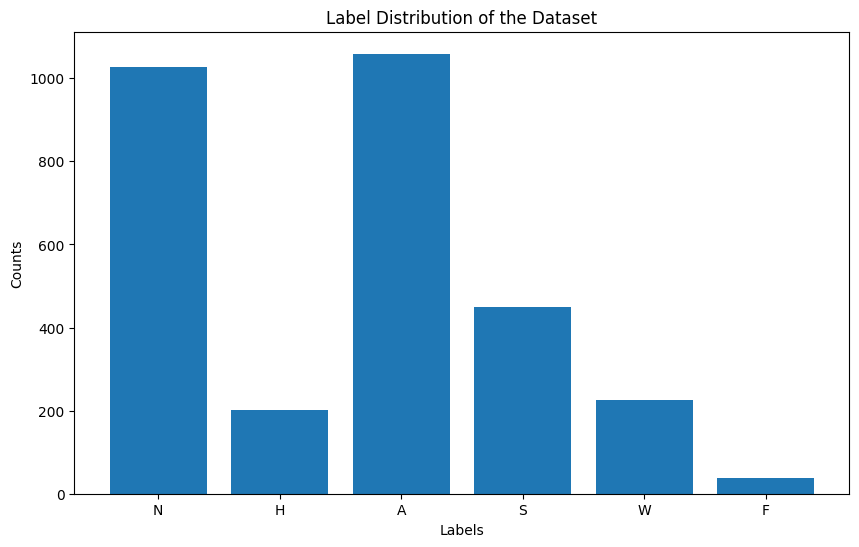

In [ ]:
label_counts = Counter()
for file in shemo_dataset.files:
    label = GeneralDataset.extract_label_char_from_filename(file[0])
    label_counts[label] += 1

labels, counts = zip(*label_counts.items())

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution of the Dataset')
plt.show()


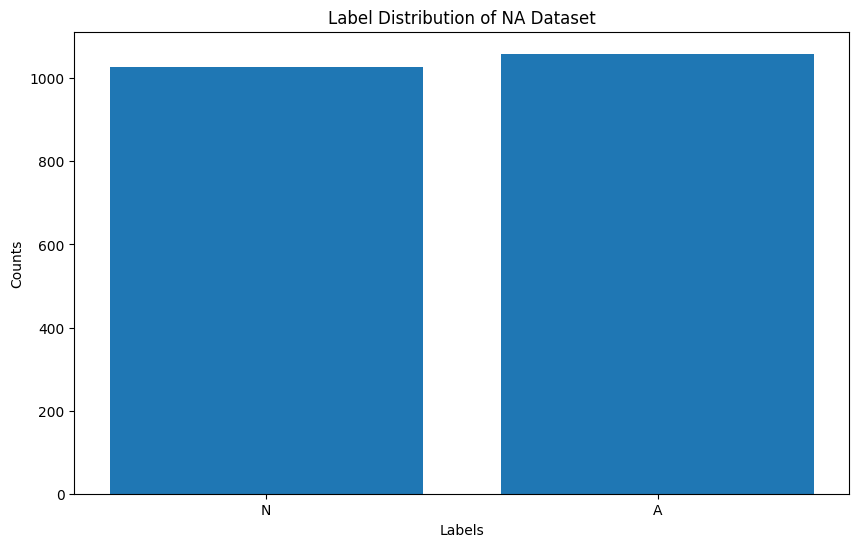

In [ ]:
class NADataset(GeneralDataset):
    def __init__(self, male_directory, female_directory, target_sample_rate, max_len=80000):
        super().__init__(male_directory, female_directory, target_sample_rate, max_len)
        # Filtrer pour les labels 'N' et 'A'
        self.files = [f for f in self.files if self.extract_label_char_from_filename(f[0]) in ['N', 'A']]

    @staticmethod
    def label_char_to_one_hot(char):
        na_label_to_one_hot = {
            'N': [0, 1],
            'A': [1, 0]
        }
        return torch.Tensor(na_label_to_one_hot[char])
    def normalize_waveform(self, waveform):
      mean = waveform.mean()
      std = waveform.std() if waveform.std() > 0 else 1.0
      normalized_waveform = (waveform - mean) / std
      return normalized_waveform

    def __getitem__(self, idx):
        # Charger les données audio et le label
        waveform, _ = self.load_audio_file(self.files[idx][0])  # Charger l'audio
        # waveform = self.normalize_waveform(waveform)
        # waveform = waveform.squeeze()
        label = self.extract_label_char_from_filename(self.files[idx][0])
        one_hot_label = self.label_char_to_one_hot(label)
        return waveform, one_hot_label

    def load_audio_file(self, filepath):
      waveform, sample_rate = torchaudio.load(filepath)
      if sample_rate != self.target_sample_rate:
          resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
          waveform = resampler(waveform)
      return waveform, sample_rate

    def __len__(self):
        return len(self.files)


shemo_NA_dataset = NADataset(
    male_directory=male_data_directory,
    female_directory=female_data_directory,
    target_sample_rate=target_sample_rate,
    max_len= 120000
)
label_counts = Counter()
for file in shemo_NA_dataset.files:
    label = NADataset.extract_label_char_from_filename(file[0])
    label_counts[label] += 1

labels, counts = zip(*label_counts.items())

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution of NA Dataset')
plt.show()

In [ ]:
# !pip install pydub
import IPython.display as ipd

def play_audio(dataset, index):
    waveform, label = dataset[index]
    label_char = 'N' if label[1] == 1 else 'A'

    audio_data = waveform.squeeze().numpy()

    print(f"Playing audio extract - Label: {label_char}")
    return ipd.Audio(audio_data, rate=dataset.target_sample_rate)

play_audio(shemo_NA_dataset, 12)


Playing audio extract - Label: A


In [ ]:
from torch.nn.utils.rnn import pad_sequence

def custom_collate_fn(batch):
    """
    Collate function to pad variable-length audio sequences in the batch.
    """
    waveforms = [torch.tensor(item[0].T) for item in batch]
    labels = [item[1] for item in batch]  # labels extraction

    padded_waveforms = pad_sequence(waveforms, batch_first=True, padding_value=0.0)
    padded_waveforms = padded_waveforms.squeeze(2)
    # attention masks
    attention_masks = torch.tensor(
        [[1] * waveform.size(0) + [0] * (padded_waveforms.size(1) - waveform.size(0))
         for waveform in waveforms]
    )

    labels = torch.stack(labels)

    return padded_waveforms, attention_masks, labels

In [ ]:
from torch.utils.data import DataLoader, random_split

# Créer une instance du dataset
shemo_NA_dataset = NADataset(
    male_directory=male_data_directory,
    female_directory=female_data_directory,
    target_sample_rate=22000,
    max_len= 80000
)

total_size = len(shemo_NA_dataset)
val_size = int(0.1 * total_size)  # 10% pour la validation
train_size = total_size - val_size

train_dataset, val_dataset = random_split(
    shemo_NA_dataset,
    [train_size, val_size]
)
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=6,
    shuffle=True,
    collate_fn=custom_collate_fn
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=6,
    shuffle=False,
    collate_fn=custom_collate_fn
)


In [ ]:
from transformers import HubertModel
from torch.nn.utils.rnn import pack_padded_sequence

# Charger le modèle HuBERT
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hubert = hubert.to(device)

# # Exemple d'entraînement
# for padded_audio, attention_mask, labels in dataloader:
#     # Envoyer les données au GPU si disponible
#     padded_audio = padded_audio.cuda()
#     attention_mask = attention_mask.cuda()
#     labels = labels.cuda()

#     # Passer les données dans HuBERT
#     outputs = hubert(input_values=padded_audio, attention_mask=attention_mask)

#     # Extraire les représentations contextuelles
#     hidden_states = outputs.last_hidden_state
#     labels = labels.to(device)
#     packed_hidden_states = pack_padded_sequence(hidden_states, lengths, batch_first=True, enforce_sorted=False)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

In [ ]:
from transformers import AutoConfig

labels = ['A', 'N']

# Créer un dictionnaire label2id et id2label
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

# Créer la configuration Hubert
config = AutoConfig.from_pretrained(
    "facebook/hubert-base-ls960",
    num_labels=len(labels),  # num_labels=2 ici
    label2id=label2id,
    id2label=id2label,
    finetuning_task="wav2vec2_clf",
)
config = "facebook/hubert-base-ls960"

In [ ]:
import torch
import torch.nn as nn
from transformers import HubertModel, HubertPreTrainedModel
from torch.nn import LSTM
from transformers.models.hubert.modeling_hubert import HubertModel


class EmotionClassifier(nn.Module):
    def __init__(self, hubert_config, classifier_type='LSTM', num_labels=2, hidden_size= 768):
        super(EmotionClassifier, self).__init__()

        self.hubert = HubertModel.from_pretrained(hubert_config)

        self.hubert = self.hubert.to(device)
        self.classifier_type = classifier_type
        self.hidden_size = hidden_size

        if classifier_type == 'LSTM':
            self.lstm = nn.LSTM(
                input_size=hidden_size,
                hidden_size=256,
                num_layers=1,
                batch_first=True,
                bidirectional=True
            )
            self.dropout = nn.Dropout(0.3)
            self.fc = nn.Linear(256 * 2, num_labels)
        self.init_weights()


    def init_weights(self):
        if self.classifier_type == 'LSTM':
            nn.init.xavier_uniform_(self.fc.weight)
            nn.init.constant_(self.fc.bias, 0)

    def forward(self, input_values, attention_mask=None, labels=None, lengths=None):

        outputs = self.hubert(input_values=input_values, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        # print(hidden_states.shape)
        if self.classifier_type == 'LSTM':
            if lengths is not None:
                packed_hidden = nn.utils.rnn.pack_padded_sequence(
                    hidden_states, lengths, batch_first=True, enforce_sorted=False
                )
                lstm_output, _ = self.lstm(packed_hidden)
                lstm_output, _ = nn.utils.rnn.pad_packed_sequence(lstm_output, batch_first=True)
            else:
                lstm_output, _ = self.lstm(hidden_states)

            x = torch.mean(lstm_output, dim=1)
            x = self.dropout(x)
            logits = self.fc(x)
            return logits


    def predict(self, input_values, attention_mask=None, lengths=None):
        with torch.no_grad():
            logits = self.forward(input_values, attention_mask, lengths=lengths)
            return torch.argmax(logits, dim=1)

    def predict_proba(self, input_values, attention_mask=None, lengths=None):
        with torch.no_grad():
            logits = self.forward(input_values, attention_mask, lengths=lengths)
            return torch.softmax(logits, dim=1)

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

model = EmotionClassifier(config, classifier_type='LSTM', num_labels=2)  # Modifie le nombre de labels selon ton cas
model = model.cuda()
for param in model.hubert.parameters():
    param.requires_grad = False
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    running_loss_val=0

    for batch_idx, (padded_audio, attention_mask, labels) in enumerate(tqdm(train_dataloader)):
        padded_audio = padded_audio.cuda()
        attention_mask = attention_mask.cuda()
        labels = labels.cuda()
        labels = torch.argmax(labels, dim=1)
        optimizer.zero_grad()
        outputs = model(padded_audio, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calcul accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

        #Val loss & accuracy
    with torch.no_grad():
      for batch_idx, (padded_audio, attention_mask, labels) in enumerate(tqdm(val_dataloader)):
          padded_audio = padded_audio.cuda()
          attention_mask = attention_mask.cuda()
          labels = labels.cuda()
          labels = torch.argmax(labels, dim=1)
          optimizer.zero_grad()
          outputs = model(padded_audio, attention_mask)
          loss = criterion(outputs, labels)
          _, predicted_val = torch.max(outputs.data, 1)

          total_val += labels.size(0)
          correct_val += (predicted_val == labels).sum().item()
          running_loss_val += loss.item()




    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}]')
    print(f'Loss: {running_loss/100:.4f}, Accuracy: {100 * correct/total:.2f}')
    print(f'Loss val : {running_loss_val/100:.4f}, Accuracy val: {100 * correct_val/total_val:.2f}')
    running_loss = 0.0


  0%|          | 0/314 [00:00<?, ?it/s]<ipython-input-8-3eeb716e4c36>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waveforms = [torch.tensor(item[0].T) for item in batch]  # Extraire les waveforms
100%|██████████| 35/35 [00:17<00:00,  2.06it/s]


Epoch [1/10], Step [35]
Loss: 1.2685, Accuracy: 81.75
Loss val : 0.0839, Accuracy val: 90.38


100%|██████████| 35/35 [00:16<00:00,  2.06it/s]


Epoch [2/10], Step [35]
Loss: 0.8927, Accuracy: 88.66
Loss val : 0.0830, Accuracy val: 90.38


100%|██████████| 35/35 [00:17<00:00,  2.06it/s]


Epoch [3/10], Step [35]
Loss: 0.7778, Accuracy: 89.78
Loss val : 0.0729, Accuracy val: 91.35


100%|██████████| 35/35 [00:17<00:00,  2.04it/s]


Epoch [4/10], Step [35]
Loss: 0.7185, Accuracy: 91.59
Loss val : 0.0708, Accuracy val: 88.94


100%|██████████| 35/35 [00:17<00:00,  2.05it/s]


Epoch [5/10], Step [35]
Loss: 0.6884, Accuracy: 90.90
Loss val : 0.0678, Accuracy val: 91.35


100%|██████████| 35/35 [00:17<00:00,  2.05it/s]


Epoch [6/10], Step [35]
Loss: 0.6300, Accuracy: 91.91
Loss val : 0.0663, Accuracy val: 93.75


100%|██████████| 35/35 [00:17<00:00,  2.06it/s]


Epoch [7/10], Step [35]
Loss: 0.6119, Accuracy: 92.44
Loss val : 0.0492, Accuracy val: 94.71


100%|██████████| 35/35 [00:17<00:00,  2.06it/s]


Epoch [8/10], Step [35]
Loss: 0.5410, Accuracy: 93.40
Loss val : 0.0482, Accuracy val: 94.71


100%|██████████| 35/35 [00:17<00:00,  2.00it/s]


Epoch [9/10], Step [35]
Loss: 0.4937, Accuracy: 93.72
Loss val : 0.0584, Accuracy val: 94.71


100%|██████████| 35/35 [00:17<00:00,  2.04it/s]

Epoch [10/10], Step [35]
Loss: 0.4689, Accuracy: 93.93
Loss val : 0.0576, Accuracy val: 91.35
